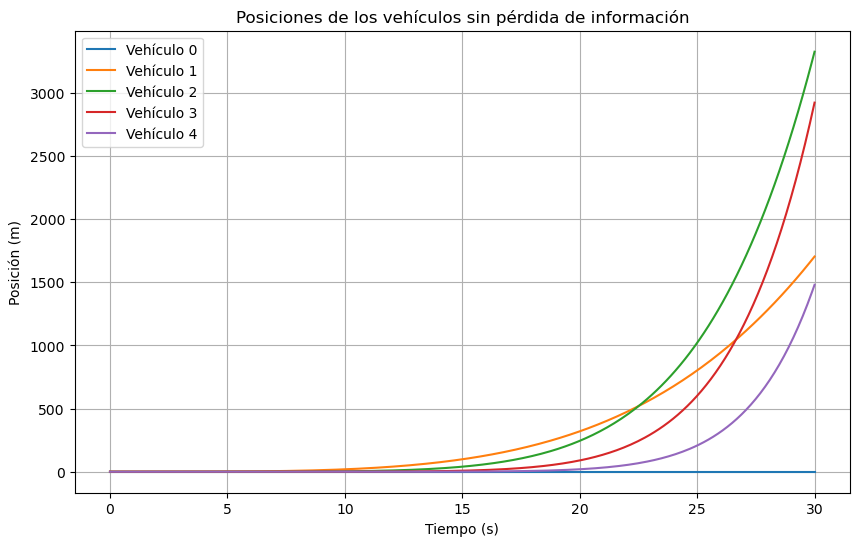

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import control

# Definir parámetros del sistema
M = 5  # Número de vehículos en el convoy
h = 5  # Constante de time-headway
T = 0.1  # Tiempo de muestreo (segundos)
Kp = 0.5  # Ganancia proporcional del controlador
Ki = 0.1  # Ganancia integral del controlador

# Definir la función de transferencia del sistema en el dominio Z
a = 0.713
b = 0.0020131
G_z = control.TransferFunction([b, 0], [1, -1 - a, a], True)
C_z = control.TransferFunction([Kp + Ki, -Kp], [1, -1], True)

# Simulación del líder
N = 300  # Número de muestras
t = np.linspace(0, N * T, N)
velocidad_lider = 10 * (1 - np.exp(-0.1 * t))  # Velocidad deseada del líder
posicion_lider = np.cumsum(velocidad_lider) * T

# Simulación de los vehículos seguidores
posiciones = np.zeros((M, N))
velocidades = np.zeros((M, N))
errores = np.zeros((M, N))

for i in range(1, M):
    error = (posicion_lider if i == 1 else posiciones[i - 1]) - posiciones[i] - h * velocidades[i]
    errores[i] = error
    # Controlador PI para seguir la referencia
    u = Kp * error + Ki * np.cumsum(errores[i]) * T
    # Simulación usando forced_response
    sistema_cerrado = control.series(C_z, G_z)
    t_out, y_out = control.forced_response(sistema_cerrado, T=t, U=u)
    posiciones[i] = y_out
    velocidades[i] = np.gradient(y_out, T)

# Gráfica de las posiciones
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, posiciones[i], label=f'Vehículo {i}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posiciones de los vehículos sin pérdida de información')
plt.legend()
plt.grid(True)
plt.show()


4 states have been removed from the model


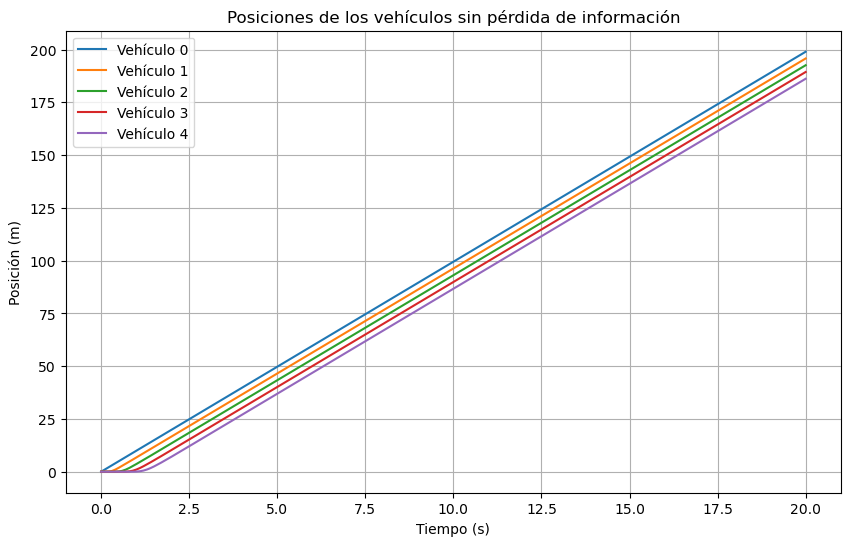

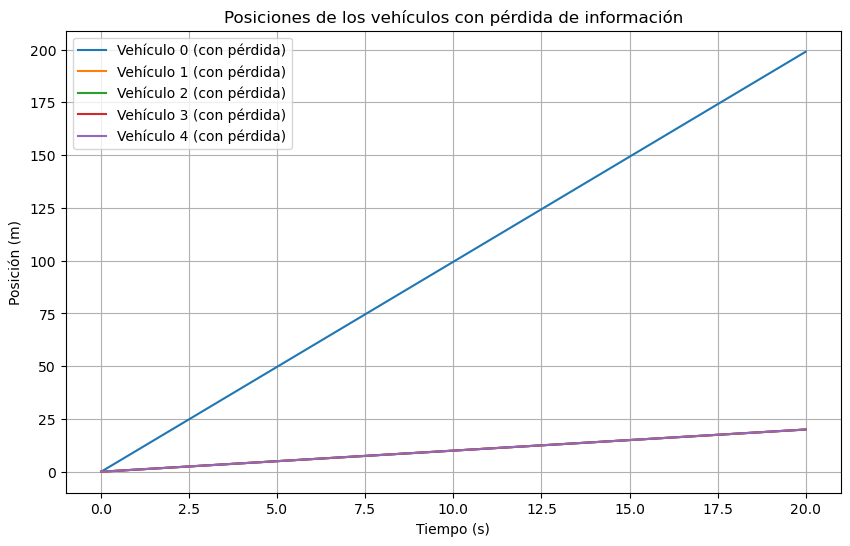

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *  # Importar funciones de la librería control con nombres similares a MATLAB

# Definir parámetros del sistema
M = 5  # Número de vehículos en el convoy
h = 3.2  # Constante de time-headway (ajustable)
T = 0.1  # Tiempo de muestreo (segundos)
Kp = 0.5  # Ganancia proporcional del controlador
Ki = 0.1  # Ganancia integral del controlador

# Definir la función de transferencia del sistema en el dominio Z
G = tf([1], [1, -1], True)  # Sistema del líder

# Controlador local en cada vehículo
a = 0.89
K = tf([1.35 / (1 + h), 0], [1, a], True) * tf([1], [1, -1], True)  # Controlador PI
H = tf([1 + h], [1], True) - tf([h], [1, 0], True)
T_closed = minreal(K * G / (1 + K * G * H))  # Sistema en lazo cerrado para cada vehículo

# Simulación del líder
t = np.linspace(0, 200 * T, 200)
y0, _ = step(G, t)

# Simulación de los vehículos seguidores sin pérdida de información
y = np.zeros((M, len(t)))
y[0, :] = y0
for i in range(1, M):
    y[i, :] = lsim(T_closed, y[i-1,:],t)[0]

# Gráfica de las posiciones sin pérdida de información
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, y[i, :], label=f'Vehículo {i}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posiciones de los vehículos sin pérdida de información')
plt.legend()
plt.grid(True)
plt.show()

# Simulación de los vehículos seguidores con pérdida de información
np.random.seed(42)  # Semilla para reproducibilidad
moneda = np.random.choice([0, 1], size=(M, len(t)), p=[0.5, 0.5])  # Pérdida aleatoria de datos con probabilidad

y_perdida = np.zeros((M, len(t)))
y_perdida[0, :] = y0
entrada = np.zeros((M, len(t)))
estimacion = np.zeros((M, len(t)))

for i in range(1, M):
    for j in range(2, len(t)):
        estimacion[i - 1, j] = y_perdida[i - 1, j - 1] + (y_perdida[i - 1, j - 1] - y_perdida[i - 1, j - 2])
        if moneda[i, j] == 1:
            entrada[i, j] = y_perdida[i - 1, j]
        else:
            entrada[i, j] = estimacion[i - 1, j]
    t_out, y_out, _ = lsim(T_closed, entrada[i, :], t)
    y_perdida[i, :] = y_out

# Gráfica de las posiciones con pérdida de información
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, y_perdida[i, :], label=f'Vehículo {i} (con pérdida)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posiciones de los vehículos con pérdida de información')
plt.legend()
plt.grid(True)
plt.show()


4 states have been removed from the model


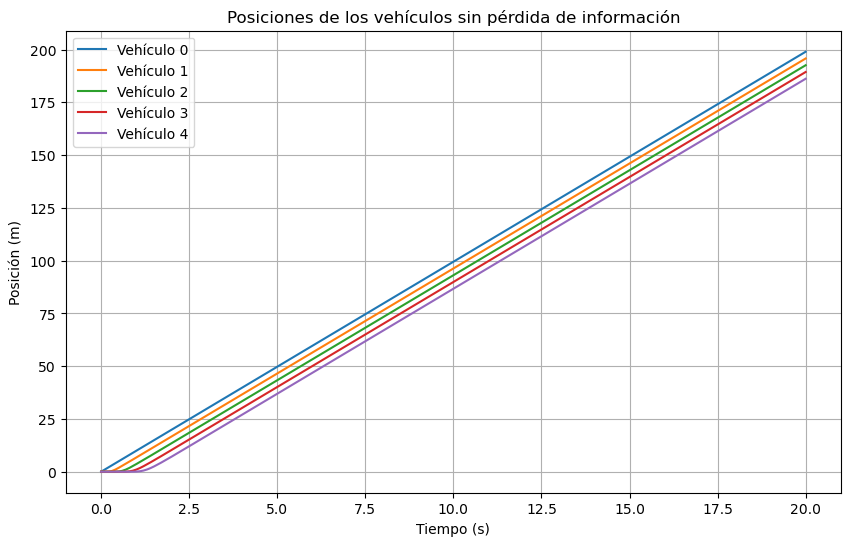

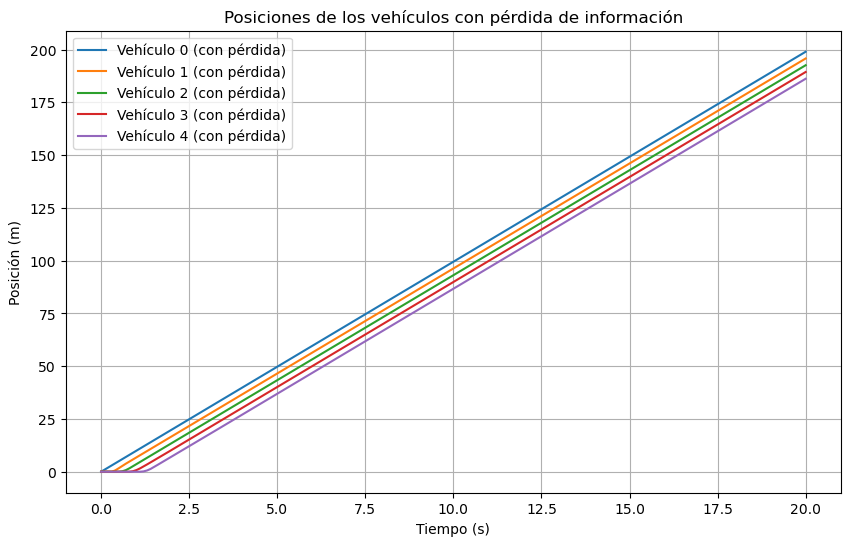

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *  # Importar funciones de la librería control con nombres similares a MATLAB

# Definir parámetros del sistema
M = 5  # Número de vehículos en el convoy
h = 3.2  # Constante de time-headway (ajustable)
T = 0.1  # Tiempo de muestreo (segundos)
Kp = 0.5  # Ganancia proporcional del controlador
Ki = 0.1  # Ganancia integral del controlador

# Definir la función de transferencia del sistema en el dominio Z
G = tf([1], [1, -1], True)  # Sistema del líder

# Controlador local en cada vehículo
a = 0.89
K = tf([1.35 / (1 + h), 0], [1, a], True) * tf([1], [1, -1], True)  # Controlador PI
H = tf([1 + h], [1], True) - tf([h], [1, 0], True)
T_closed = minreal(K * G / (1 + K * G * H))  # Sistema en lazo cerrado para cada vehículo

# Simulación del líder
t = np.linspace(0, 200 * T, 200)
y0, _ = step(G, t)

# Simulación de los vehículos seguidores sin pérdida de información
y = np.zeros((M, len(t)))
y[0, :] = y0
for i in range(1, M):
    y[i, :] = lsim(T_closed, y[i - 1, :], t)[0]

# Gráfica de las posiciones sin pérdida de información
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, y[i, :], label=f'Vehículo {i}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posiciones de los vehículos sin pérdida de información')
plt.legend()
plt.grid(True)
plt.show()

# Simulación de los vehículos seguidores con pérdida de información
np.random.seed(42)  # Semilla para reproducibilidad
moneda = np.random.choice([0, 1], size=(M, len(t)))  # Pérdida aleatoria de datos

y_perdida = np.zeros((M, len(t)))
y_perdida[0, :] = y0
entrada = np.zeros((M, len(t)))
estimacion = np.zeros((M, len(t)))

for i in range(1, M):
    for j in range(2, len(t)):
        estimacion[i - 1, j] = y_perdida[i - 1, j - 1] + (y_perdida[i - 1, j - 1] - y_perdida[i - 1, j - 2])
        entrada[i, j] = moneda[i, j] * (y_perdida[i - 1, j] - estimacion[i - 1, j]) + estimacion[i - 1, j]
    y_perdida[i, :] = lsim(T_closed, entrada[i, :], t)[0]


# Gráfica de las posiciones con pérdida de información
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, y_perdida[i, :], label=f'Vehículo {i} (con pérdida)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posiciones de los vehículos con pérdida de información')
plt.legend()
plt.grid(True)
plt.show()


4 states have been removed from the model


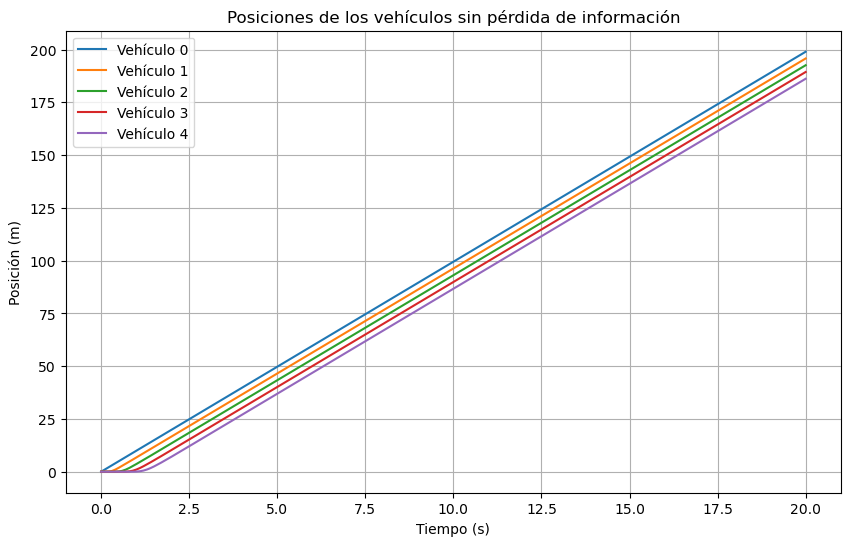

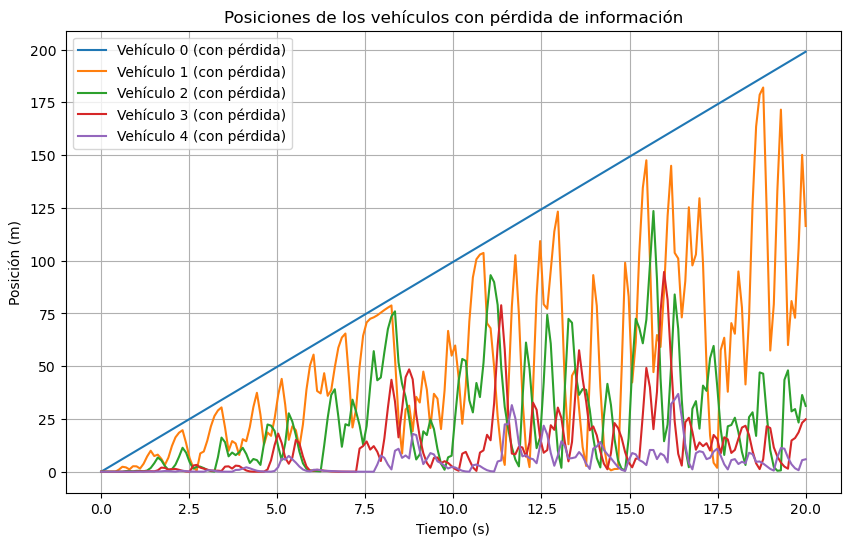

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *  # Importar funciones de la librería control con nombres similares a MATLAB

np.random.seed(42)

# Definir parámetros del sistema
M = 5  # Número de vehículos en el convoy
h = 3.2  # Constante de time-headway (ajustable)
T = 0.1  # Tiempo de muestreo (segundos)
Kp = 0.5  # Ganancia proporcional del controlador
Ki = 0.1  # Ganancia integral del controlador

# Definir la función de transferencia del sistema en el dominio Z
G = tf([1], [1, -1], True)  # Sistema del líder

# Controlador local en cada vehículo
a = 0.89
K = tf([1.35 / (1 + h), 0], [1, a], True) * tf([1], [1, -1], True)  # Controlador PI
H = tf([1 + h], [1], True) - tf([h], [1, 0], True)
T_closed = minreal(K * G / (1 + K * G * H))  # Sistema en lazo cerrado para cada vehículo

# Simulación del líder
t = np.linspace(0, 200 * T, 200)
y0, _ = step(G, t)

# Simulación de los vehículos seguidores sin pérdida de información
y = np.zeros((M, len(t)))
y[0, :] = y0
for i in range(1, M):
    y[i, :] = lsim(T_closed, y[i - 1, :], t)[0]

# Gráfica de las posiciones sin pérdida de información
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, y[i, :], label=f'Vehículo {i}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posiciones de los vehículos sin pérdida de información')
plt.legend()
plt.grid(True)
plt.show()

# Simulación de los vehículos seguidores con pérdida de información
np.random.seed(42)  # Semilla para reproducibilidad
moneda = np.random.choice([0, 1], size=(M, len(t)), p=[0.5, 0.5])  # Pérdida aleatoria de datos con 50% de probabilidad

y_perdida = np.zeros((M, len(t)))
y_perdida[0, :] = y0
entrada = np.zeros((M, len(t)))

for i in range(1, M):
    for j in range(2, len(t)):
        if moneda[i, j] == 1:
            entrada[i, j] = y_perdida[i - 1, j]  # Sin pérdida, usar el valor real
        else:
            entrada[i, j] = 0  # Con pérdida, entrada es cero para simular pérdida completa de información
    y_perdida[i, :] = lsim(T_closed, entrada[i, :], t)[0]

# Gráfica de las posiciones con pérdida de información
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, y_perdida[i, :], label=f'Vehículo {i} (con pérdida)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posiciones de los vehículos con pérdida de información')
plt.legend()
plt.grid(True)
plt.show()


4 states have been removed from the model
4 states have been removed from the model
4 states have been removed from the model
4 states have been removed from the model
4 states have been removed from the model


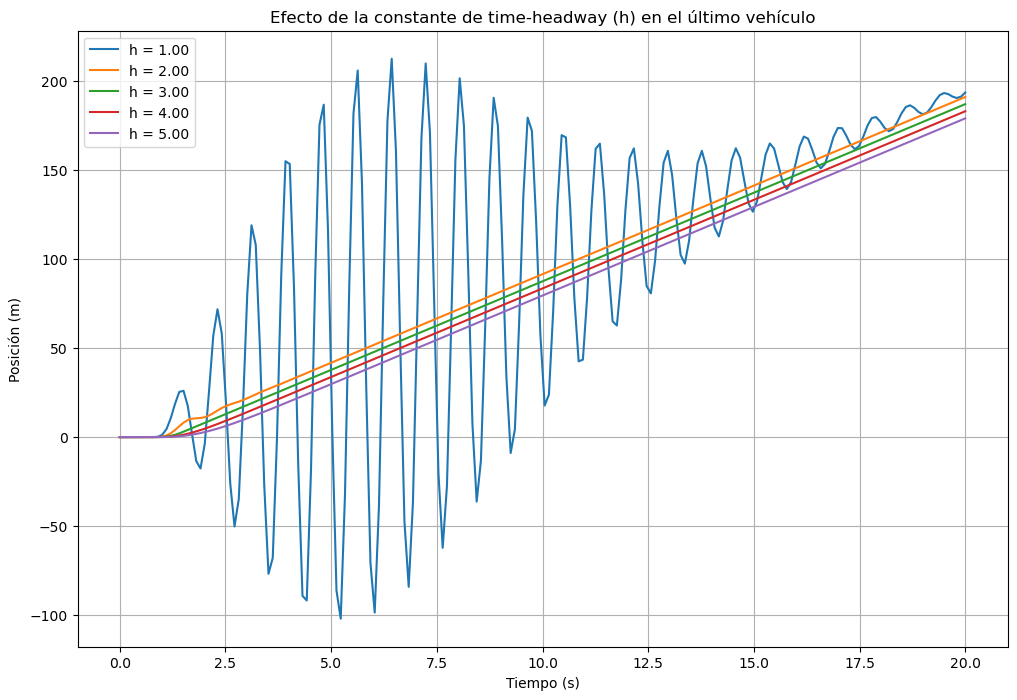

In [11]:
# Variar la constante de time-headway (h) usando np.linspace y observar su efecto
h_values = np.linspace(1.0, 5.0, 5)  # Valores de h igualmente espaciados
results = []

plt.figure(figsize=(12, 8))

for h in h_values:
    # Redefinir controlador y sistema cerrado con el nuevo h
    K = tf([1.35 / (1 + h), 0], [1, a], True) * tf([1], [1, -1], True)  # Controlador PI
    H = tf([1 + h], [1], True) - tf([h], [1, 0], True)
    T_closed = minreal(K * G / (1 + K * G * H))  # Sistema en lazo cerrado para cada vehículo

    # Simulación de los vehículos seguidores sin pérdida de información
    y = np.zeros((M, len(t)))
    y[0, :] = y0
    for i in range(1, M):
        y[i, :] = lsim(T_closed, y[i - 1, :], t)[0]

    # Guardar los resultados para cada h
    results.append(y)

    # Graficar los resultados del último vehículo
    plt.plot(t, y[-1, :], label=f'h = {h:.2f}')

# Configuración de la gráfica
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Efecto de la constante de time-headway (h) en el último vehículo')
plt.legend()
plt.grid(True)
plt.show()


3 states have been removed from the model


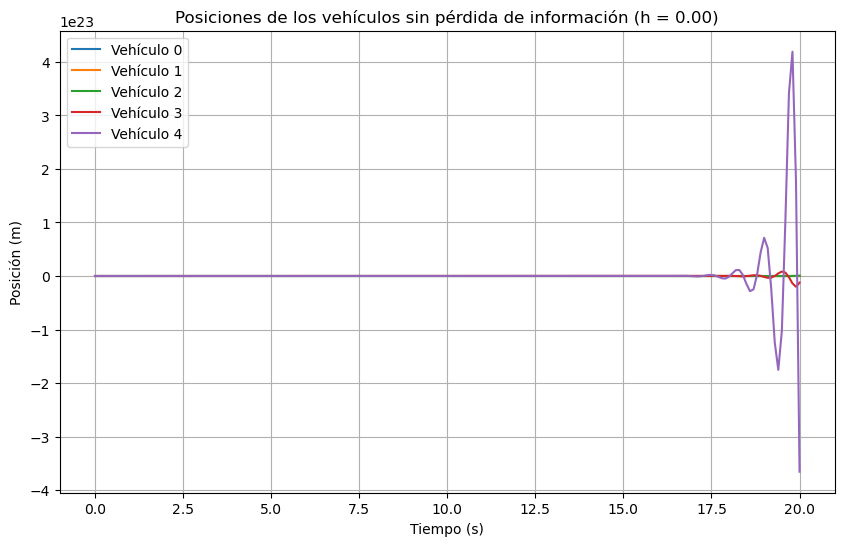

4 states have been removed from the model


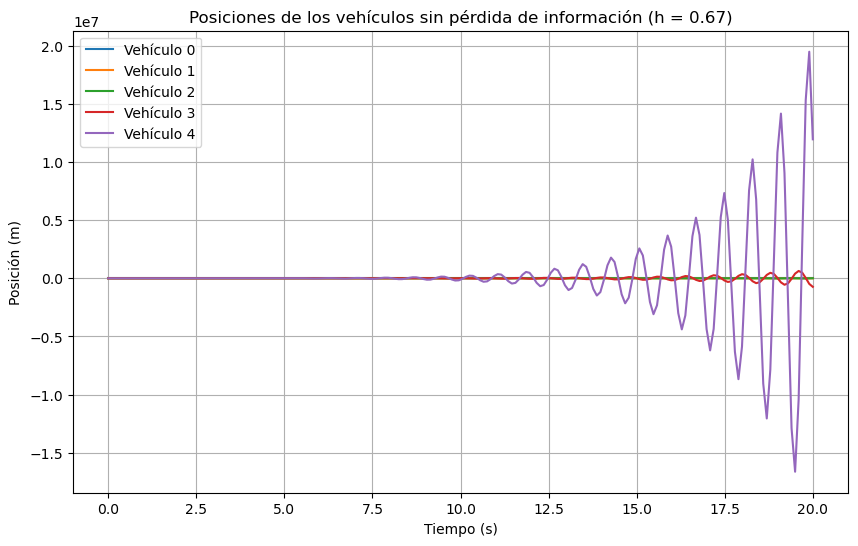

4 states have been removed from the model


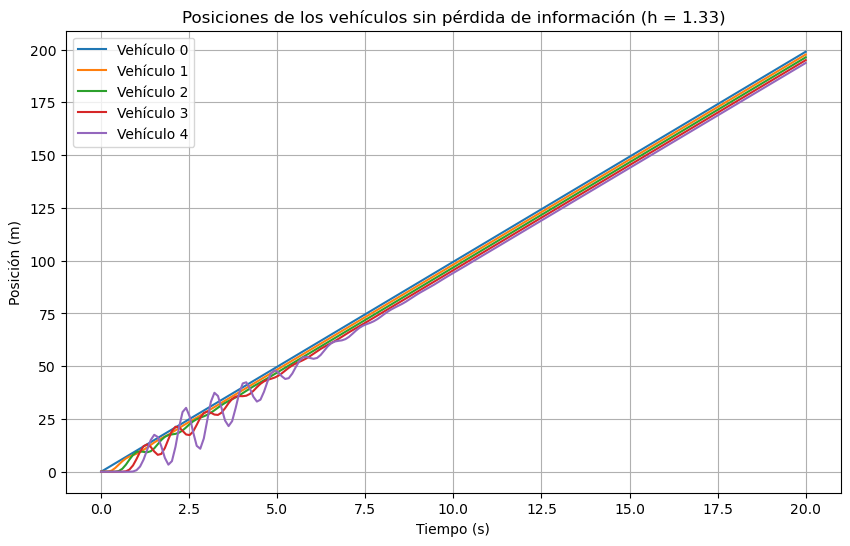

4 states have been removed from the model


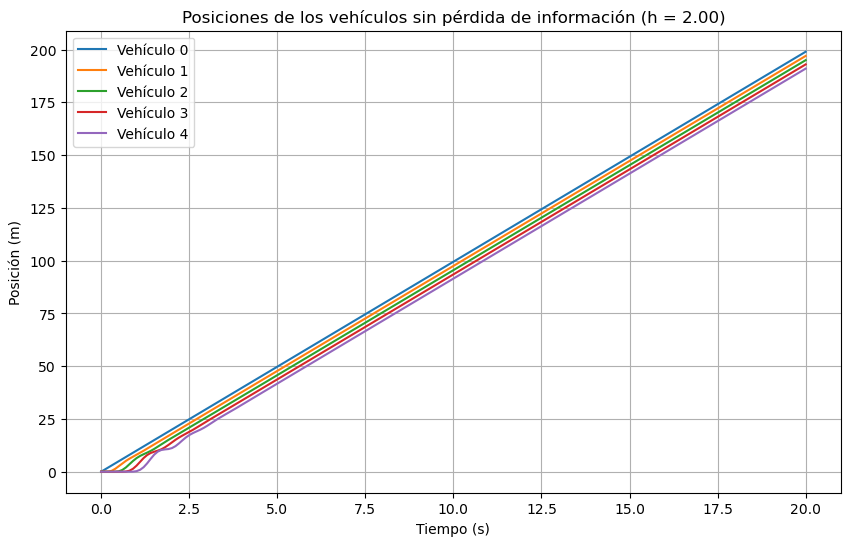

4 states have been removed from the model


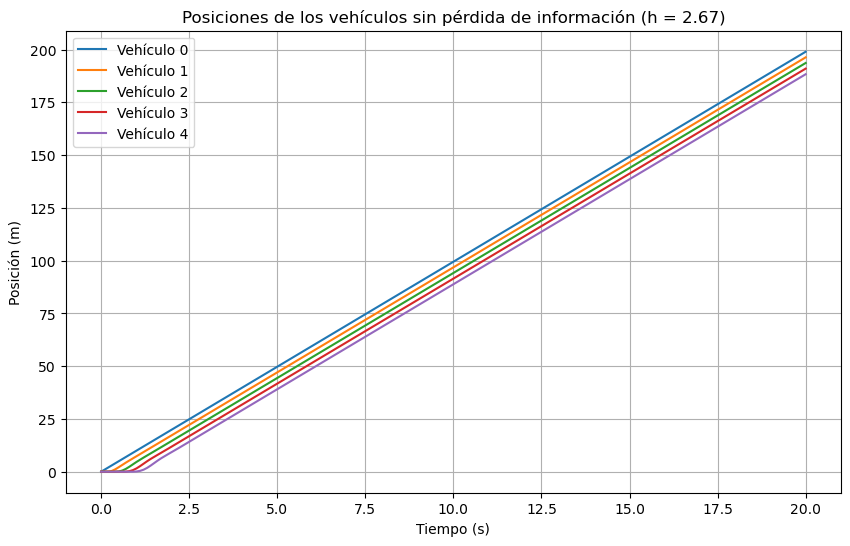

4 states have been removed from the model


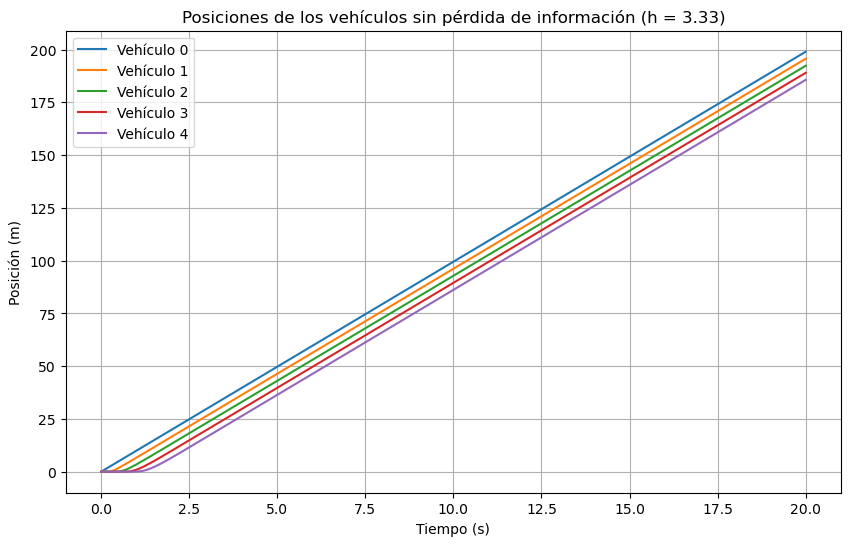

4 states have been removed from the model


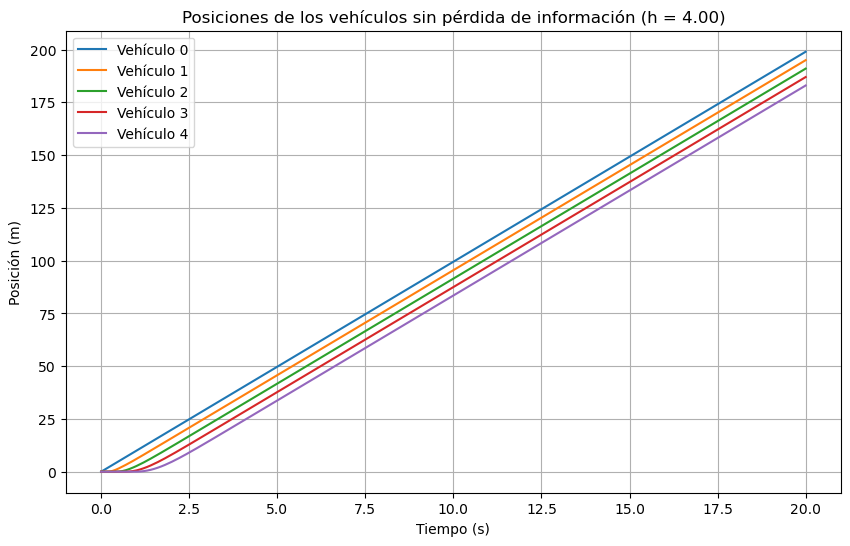

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *

# Definir parámetros iniciales
M = 5  # Número de vehículos en el convoy
T = 0.1  # Tiempo de muestreo (segundos)
Kp = 0.5  # Ganancia proporcional del controlador
Ki = 0.1  # Ganancia integral del controlador
h_values = np.linspace(0, 4, 7)  # Rango de valores de h para iterar

# Función de transferencia del sistema en el dominio Z
G = tf([1], [1, -1], True)  # Sistema del líder

# Tiempo de simulación
t = np.linspace(0, 200 * T, 200)

for h in h_values:
    # Controlador local en cada vehículo
    a = 0.89
    K = tf([1.35 / (1 + h), 0], [1, a], True) * tf([1], [1, -1], True)  # Controlador PI
    H = tf([1 + h], [1], True) - tf([h], [1, 0], True)
    T_closed = minreal(K * G / (1 + K * G * H))  # Sistema en lazo cerrado para cada vehículo

    # Simulación del líder
    y0, _ = step(G, t)

    # Simulación de los vehículos seguidores sin pérdida de información
    y = np.zeros((M, len(t)))
    y[0, :] = y0
    for i in range(1, M):
        y[i, :] = lsim(T_closed, y[i - 1, :], t)[0]

    # Gráfica de las posiciones sin pérdida de información para el valor actual de h
    plt.figure(figsize=(10, 6))
    for i in range(M):
        plt.plot(t, y[i, :], label=f'Vehículo {i}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Posición (m)')
    plt.title(f'Posiciones de los vehículos sin pérdida de información (h = {h:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()



3 states have been removed from the model


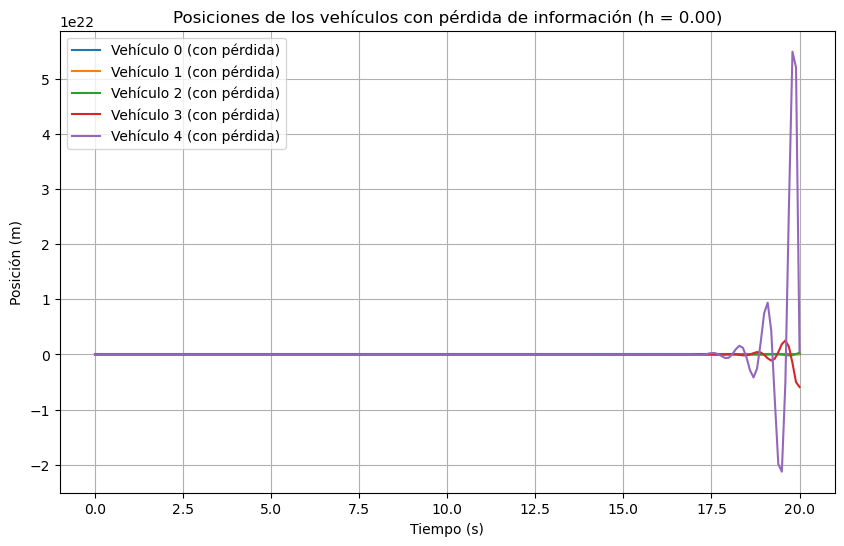

4 states have been removed from the model


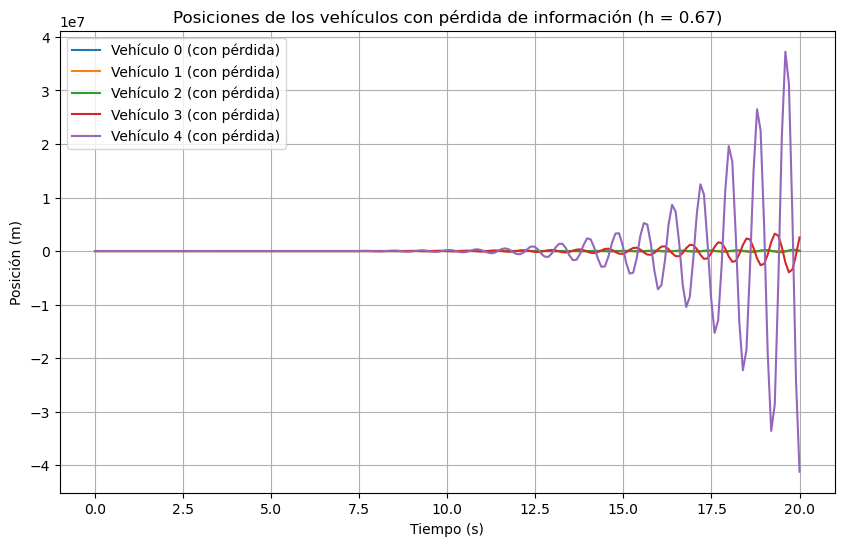

4 states have been removed from the model


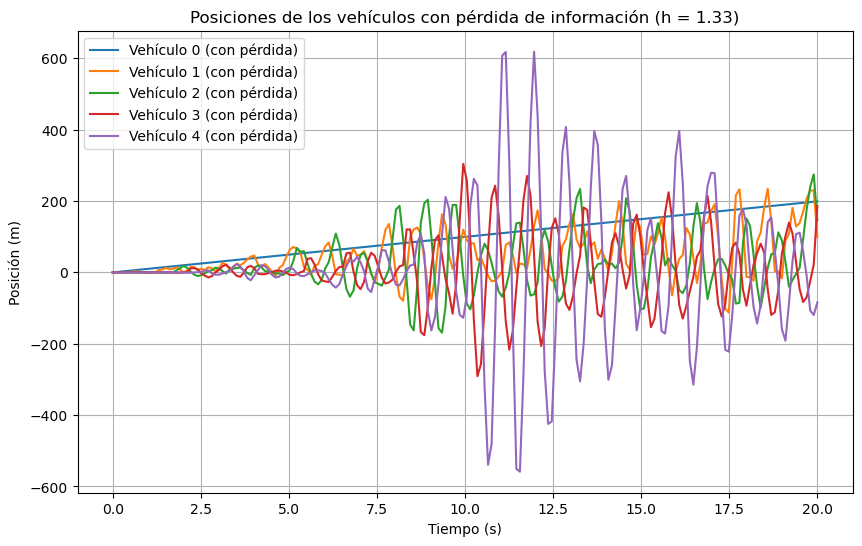

4 states have been removed from the model


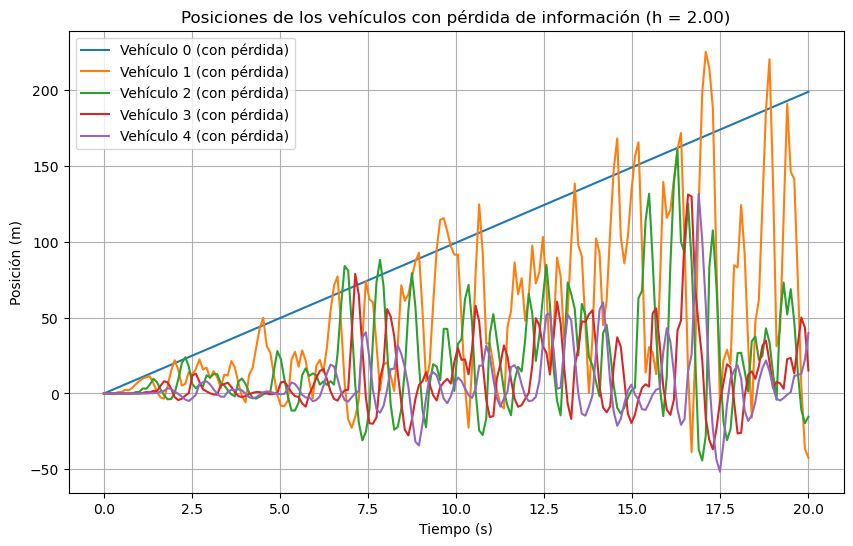

4 states have been removed from the model


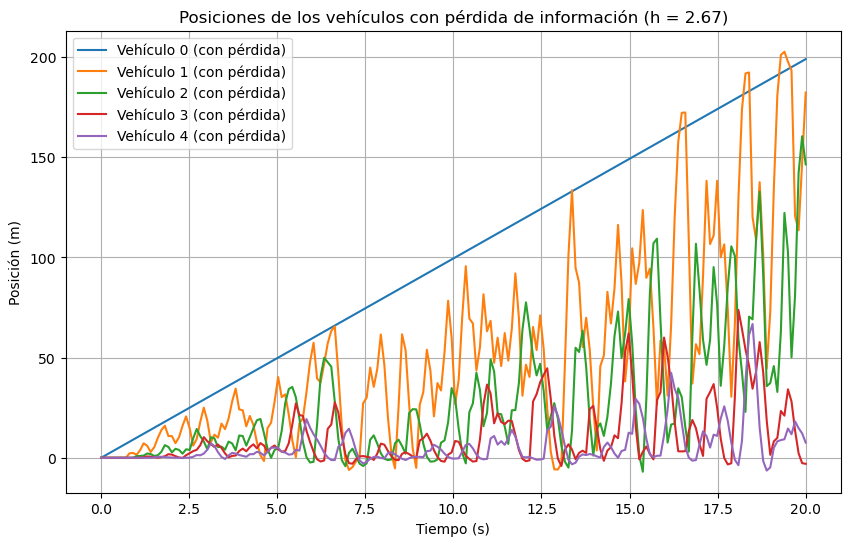

4 states have been removed from the model


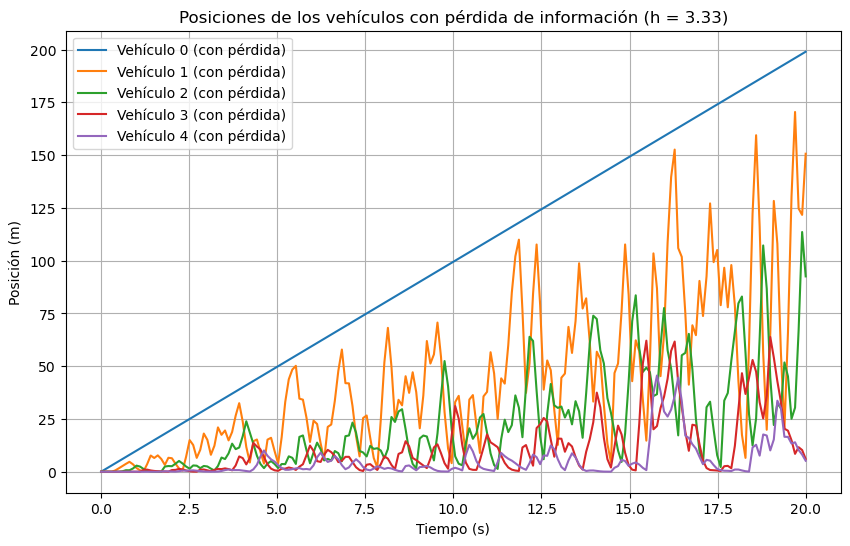

4 states have been removed from the model


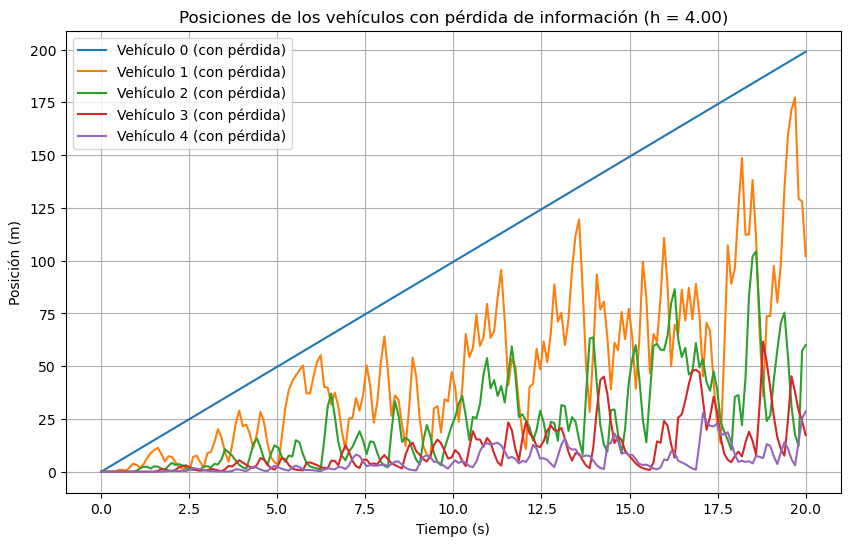

In [24]:
for h in h_values:
    # Controlador local en cada vehículo
    a = 0.89
    K = tf([1.35 / (1 + h), 0], [1, a], True) * tf([1], [1, -1], True)  # Controlador PI
    H = tf([1 + h], [1], True) - tf([h], [1, 0], True)
    T_closed = minreal(K * G / (1 + K * G * H))  # Sistema en lazo cerrado para cada vehículo

    # Simulación del líder
    y0, _ = step(G, t)

    # Inicialización de datos
    y_perdida = np.zeros((M, len(t)))
    entrada = np.zeros((M, len(t)))
    moneda = np.random.choice([0, 1], size=(M, len(t)), p=[0.5, 0.5])  # Pérdida aleatoria de datos (50%)

    # Simulación de los vehículos seguidores con pérdida de información
    y_perdida[0, :] = y0
    for i in range(1, M):
        for j in range(2, len(t)):
            if moneda[i, j] == 1:
                entrada[i, j] = y_perdida[i - 1, j]  # Sin pérdida, usar el valor real
            else:
                entrada[i, j] = 0  # Con pérdida, entrada es cero
        y_perdida[i, :] = lsim(T_closed, entrada[i, :], t)[0]

    # Gráfica de las posiciones con pérdida de información para el valor actual de h
    plt.figure(figsize=(10, 6))
    for i in range(M):
        plt.plot(t, y_perdida[i, :], label=f'Vehículo {i} (con pérdida)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Posición (m)')
    plt.title(f'Posiciones de los vehículos con pérdida de información (h = {h:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()